In [ ]:
import torch 
import torch.nn as nn
from torchvision.transforms import v2, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchmetrics import Accuracy

from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json
from math import ceil

In [2]:
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

alpha, beta = 1.2, 1.1

scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [13]:
"""
Fundamental convolution block:
    1 ==> Convolution layer
    2 ==> Batch normalization
    3 ==> Silu activation function
"""

class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=groups), # Specified to control how convolution is applied to input
                                      # If group = 1, kernel is applied to one channel only
                                      # if group = input channel, kernel is applied to one channel only

            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    
    def forward(self, x):
        return self.block(x)

In [14]:
"""
Squeeze and Excitation Block:
    Goal: To enhance feature representation by selectively amplifying important channels
    Mechanism: Take number of input channels as input and applying adaptive pooling to condense spatial dimensions
"""

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

In [15]:
"""
MobileNet-style Convolution Block (MBConv):
    Depthwise separable convolutions
    Squeeze-and-excitation block (SE)
"""

class MBConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, ratio, reduction=2):
        super(MBConv, self).__init__()

        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        # Squeeze and excitation block
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels=in_channels,
                                         out_channels=hidden_dim,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1)
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=hidden_dim),

            SqueezeExcitation(in_channels=hidden_dim,
                              reduced_dim=reduced_dim),

            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=out_channels,
                      kernel_size=1),

            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        if self.expand:
            x = self.expand_conv(inputs)
        else:
            x = inputs
            
        return self.conv(x)

In [16]:
"""
EfficientNet Class
"""

class EfficientNet(nn.Module):
    def __init__(self, model_name, output, mb_params, dropout_newVal):
        super(EfficientNet, self).__init__()
        
        phi, resolution, dropout = scale_values[model_name]

        if dropout_newVal != None:
            dropout = dropout_newVal

        if mb_params == None:
            mb_params = basic_mb_params

        self.mb_params = mb_params
        self.depth_factor, self.width_factor = alpha**phi, beta**phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.feature_extractor()
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),

            nn.Linear(in_features=self.last_channels,
                      out_features=output),
        )

    def feature_extractor(self):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(3, channels, 3, stride=2, padding=1)] # Stem convolution layer
        in_channels = channels

        for k, c_o, repeat, s, n in self.mb_params:
            # For numeric stability, we multiply and divide by 4
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                if layer == 0:
                  stride = s
                else:
                  stride = 1
                features.append(
                        MBConv(in_channels=in_channels,
                               out_channels=out_channels,
                               ratio=k,
                               stride=stride,
                               kernel_size=n,
                               padding=(n//2))
                )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels=in_channels,
                      out_channels=self.last_channels,
                      kernel_size=1,
                      stride=1,
                      padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        
        return self.classifier(self.flatten(x))

In [7]:
## Dictionary for encoding labels

labelToNum_dict = {
    "angry" : 0,
    "disgust" : 1,
    "fear" : 2,
    "happy" : 3,
    "neutral" : 4,
    "sad" : 5,
    "surprise" : 6,
}

numTolabel_dict = {
    0 : "angry",
    1 : "disgust",
    2 : "fear",
    3 : "happy",
    4 : "neutral",
    5 : "sad",
    6: "surprise"
}

In [8]:
def loadDataset(res, batch_size, datasetType):
    base_dir = os.getcwd()
    folder_dir = os.path.join(base_dir, "processed_data", datasetType)
    
    transformation = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), # Convert image to float ranging from 0 - 1
        v2.Resize((res, res)),
    ])

    dataset = ImageFolder(folder_dir, transform=transformation)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader


Train features batch shape: torch.Size([32, 3, 224, 224])
Train labels batch size: torch.Size([32])


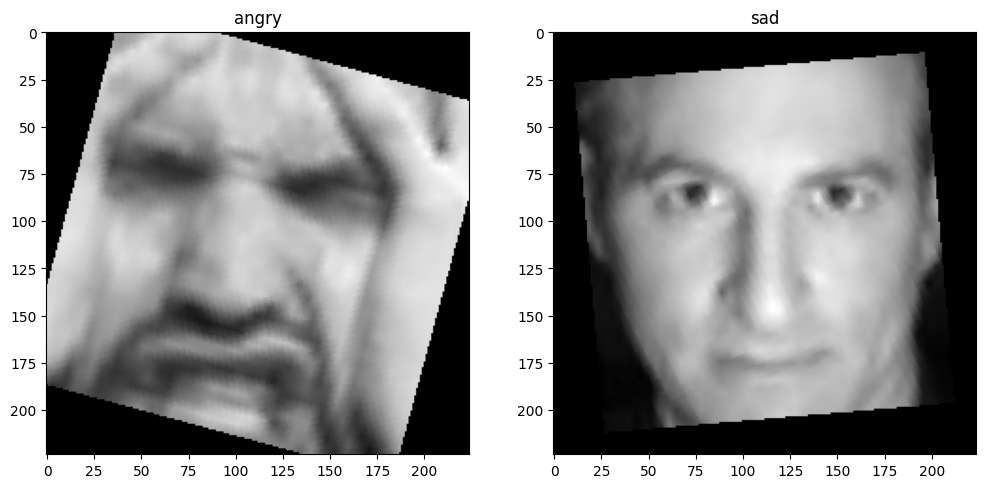

In [9]:
## New loading and testing train and validation datasets

train_loader = loadDataset(224, 32, "train")
val_loader = loadDataset(224, 32, "validation")

x_train, y_train = next(iter(train_loader))
x_val, y_val = next(iter(val_loader))

print(f"Train features batch shape: {x_train.size()}")
print(f"Train labels batch size: {y_train.size()}")

imgTrain = x_train[0].squeeze()
labelTrain = y_train[0]

imgVal = x_val[0].squeeze()
labelVal = y_val[0]

fig = plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(imgTrain.permute(1,2,0))
plt.title(numTolabel_dict[labelTrain.item()])

plt.subplot(1,2,2)
plt.imshow(imgVal.permute(1,2,0))
plt.title(numTolabel_dict[labelVal.item()])
plt.show()


In [10]:
def setHyperparameters(model_type, num_class, batchSize, learningRate, device, mb_params, newDropoutRate, optimChoice):
    
    phi, resolution, dropout = scale_values[model_type]

    train_loader = loadDataset(resolution, batchSize, "train")
    test_loader = loadDataset(resolution, batchSize, "test")
    val_loader = loadDataset(resolution, batchSize, "validation")

    model = EfficientNet(model_name=model_type,
                         output=num_class,
                         mb_params=mb_params,
                         dropout_newVal=newDropoutRate)
    
    model.to(device)

    match (optimChoice):
        case "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        
        case "AdamW":
            optimizer = torch.optim.AdamW(model.parameters(), lr=learningRate)
        
        case "Adadelta":
            optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate)
        
        case "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        
        case _:
            print("ERROR. Optimizer choice inputted is not included in selection.\n PLEASE RESET MODEL OPTIMIZER's CHOICE.\n")

    return model, train_loader, test_loader, val_loader, optimizer

In [11]:
## Testing for whether CUDA is available for training

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4060 Ti


In [35]:
## Function for training model

def train_model(model, train_loader, device, lossFn, accFn, optimizer):
    
    torch.manual_seed(42) # 42 is the answer to everything!
    
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training Model on Num Batches")):
        model.train()

        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # Still in logits from (probabilities)

        # 2. Calculate loss (per batch)
        loss = lossFn(y_pred, y)
        train_loss += loss
        train_acc += accFn(y_pred.argmax(dim=1), y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
    # Divide total train loss and accuracy by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_acc *= 100

    return model, optimizer, train_loss, train_acc

In [36]:
## Function for testing model

def test_model(model, test_loader, device, lossFn, accFn):
    
    torch.manual_seed(42)

    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(test_loader, desc="Testing Model")):
            
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss (accumulatively)
            test_loss += lossFn(test_pred, y)

            # 3. Calculate accuracy (preds need to be same as y)
            test_acc += accFn(test_pred.argmax(dim=1), y)
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_loader)

        # Times 100 to make it into a percentage
        test_acc *= 100
    
    return model, test_loss, test_acc

In [60]:
## Function for entire training and testing loop with data saving

def model_train_test(model, epochs, train_loader, test_loader, device, lossFn, accFn, optimizer):
    history = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in range(0, epochs):

        print(f"\nEpoch {epoch+1} / {epochs}: ---------------------------")

        ### Training
        model, optimizer, train_loss, train_acc = train_model(model, train_loader, device, lossFn, accFn, optimizer)

        ### Testing
        model, test_loss, test_acc = test_model(model, test_loader, device, lossFn, accFn)
        
        print(f"\nTrain loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%")
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
    
    print("\n-------Model has finished training-------\n")
    
    return model, history
    

In [17]:
## Function to save model and model weights

def save_model_and_modelWeights(model, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)

    modelStateDictName = model_name + "_weights.pth"
    modelEntireName = model_name + ".pth"

    modelStateDict_path = os.path.join(model_path, modelStateDictName)
    modelEntire_path = os.path.join(model_path, modelEntireName)

    # Save model's weight only
    if os.path.isfile(modelStateDict_path):
        print(f"\n{model_name} state dictionary file existed previously. New {model_name}'s state is not saved.")
    else:
        torch.save(model.state_dict(), modelStateDict_path)
        print(f"\n{model_name}'s state file has been successfully saved.")

    # Save entire model including layers and weights
    if os.path.isfile(modelEntire_path):
        print(f"\n{model_name} file existed previously. New {model_name} is not saved.")
    else:
        torch.save(model, modelEntire_path)
        print(f"\n{model_name} has been successfully saved.")

In [18]:
def save_modelSettings(model_settings, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    
    json_path = os.path.join(model_path, model_name+"_settings.json")

    if os.path.isfile(json_path):
        print(f"\n{model_name}'s settings file existed previously. New {model_name}'s settings file is not saved.\n")

    else:
        with open(json_path, 'w') as file:
            json.dump(model_settings, file)
        
        print(f"\n{model_name}'s setting has been saved.\n")

In [19]:
## Function to show and save model history

def show_and_save_trainTest_history(history, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    
    json_path = os.path.join(model_path, model_name+"_history.json")

    # Convert json in tensor to normal data

    new_history = {}

    for key, dataL in history.items():
        new_history[key] = []
        for i in range(0, len(dataL)):
            new_history[key].append(dataL[i].item())

    if os.path.isfile(json_path):
        print(f"\n{model_name}'s history file existed previously. New {model_name}'s history file is not saved.\n")

    else:
        with open(json_path, 'w') as file:
            json.dump(new_history, file)
        
        print(f"\n{model_name}'s training history has been saved.\n")

    # Checking model's training history

    for val_type in history:
        print(val_type)
        dataList = history[val_type]
        for i in range(0, len(history[val_type])):
            print(f"{i+1}. {dataList[i]:.4f}")
        print("")

In [50]:
## Class for model hyperparameters and training settings

class ModelSet:
    def __init__(self, model_name, model_type, epochs, batchSize, learningRate, mb_params, newDropoutRate, optimChoice):
        self.model_name = model_name
        self.model_type = model_type
        self.num_class = 7
        self.epochs = epochs
        self.batchSize = batchSize
        self.learningRate = learningRate
        self.mb_params = mb_params
        self.newDropoutRate = newDropoutRate
        self.history = None
        self.optimChoice = optimChoice
    
    def model_setup(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model, self.train_loader, self.test_loader, self.val_loader, self.optimizer = setHyperparameters(model_type=self.model_type,
                                                                                                              num_class=self.num_class,
                                                                                                              batchSize=self.batchSize,
                                                                                                              learningRate=self.learningRate,
                                                                                                              device=self.device,
                                                                                                              mb_params=self.mb_params,
                                                                                                              newDropoutRate=self.newDropoutRate,
                                                                                                              optimChoice=self.optimChoice)

        self.lossFn = nn.CrossEntropyLoss()

        self.accFn = Accuracy('multiclass', num_classes=self.num_class).to(self.device)
    
    ## Function to save model settings as json file

    def generate_modelSettings_dict(self):

        phi, res, ori_dp_rate = scale_values[self.model_type]

        if self.newDropoutRate == None:
            self.newDropoutRate = ori_dp_rate

        modelSettings = {"model_name": self.model_name,
                         "model_type": self.model_type,
                         "num_class": 7,
                         "epochs": self.epochs,
                         "batch_size": self.batchSize,
                         "learning_rate": self.learningRate,
                         "MBConv parameters": self.mb_params,
                         "dropout_rate": self.newDropoutRate,
                         "optimizer": self.optimChoice,
                         "loss_function": "Cross Entropy Loss"}
        
        return modelSettings

In [51]:
## Do not change this, only for reference!!
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Change any settings you want on this one
mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Do not change anything with it, only for reference!!
scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [64]:
## Creating a model

if (mb_params == basic_mb_params):
    mb_params = basic_mb_params

model_2 = ModelSet(model_name="model_2", # Change names if you want to save different versions of models
                   model_type="b0", # from b0 --> b7
                   epochs=30, 
                   batchSize=32, # Typically in the power of 2
                   learningRate=0.0012, # Different choices for different optimizers
                   mb_params=mb_params, # Can refer to previous block / If None, use basic_mb_params
                   newDropoutRate=0.3, # Can refer to previous block / If None, use basic dropout rate
                   optimChoice="Adam") # Available choice: Adam, AdamW, Adadelta, SGD

model_2.model_setup() # Setting up everything

modelSettings = model_2.generate_modelSettings_dict()

In [65]:
## Generate model summary

summary(model_2.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
         ConvBlock-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             320
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              SiLU-7         [-1, 32, 112, 112]               0
         ConvBlock-8         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             528
             SiLU-11             [-1, 16, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             544
          Sigmoid-13             [-1, 32, 1, 1]               0
SqueezeExcitation-14         [-1, 32, 1

In [66]:
## Start training and testing loop

model_2.model, model_2.history = model_train_test(model=model_2.model,
                                          epochs=model_2.epochs,
                                          train_loader=model_2.train_loader,
                                          test_loader=model_2.test_loader,
                                          device=model_2.device,
                                          lossFn=model_2.lossFn,
                                          accFn=model_2.accFn,
                                          optimizer=model_2.optimizer)


Epoch 1 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.25it/s]



Train loss: 1.8183, Train acc: 24.32%
Test loss: 1.8174, Test acc: 24.53%


Epoch 2 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.43it/s]



Train loss: 1.7661, Train acc: 27.04%
Test loss: 1.7151, Test acc: 33.03%


Epoch 3 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.02it/s]



Train loss: 1.5991, Train acc: 36.18%
Test loss: 1.5682, Test acc: 37.83%


Epoch 4 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.55it/s]



Train loss: 1.4795, Train acc: 41.27%
Test loss: 1.4869, Test acc: 40.81%


Epoch 5 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 11.19it/s]



Train loss: 1.4045, Train acc: 44.61%
Test loss: 1.4295, Test acc: 42.80%


Epoch 6 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00, 10.07it/s]



Train loss: 1.3307, Train acc: 48.28%
Test loss: 1.3439, Test acc: 47.31%


Epoch 7 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.93it/s]



Train loss: 1.2559, Train acc: 51.56%
Test loss: 1.3228, Test acc: 48.29%


Epoch 8 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.55it/s]



Train loss: 1.1890, Train acc: 54.65%
Test loss: 1.3276, Test acc: 48.73%


Epoch 9 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.33it/s]



Train loss: 1.1320, Train acc: 56.78%
Test loss: 1.3108, Test acc: 50.01%


Epoch 10 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.04it/s]



Train loss: 1.0802, Train acc: 58.79%
Test loss: 1.2927, Test acc: 51.47%


Epoch 11 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.54it/s]



Train loss: 1.0277, Train acc: 60.68%
Test loss: 1.2669, Test acc: 52.61%


Epoch 12 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.48it/s]



Train loss: 0.9810, Train acc: 62.58%
Test loss: 1.3808, Test acc: 51.17%


Epoch 13 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.23it/s]



Train loss: 0.9326, Train acc: 64.39%
Test loss: 1.3234, Test acc: 51.83%


Epoch 14 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.56it/s]



Train loss: 0.8888, Train acc: 66.11%
Test loss: 1.3392, Test acc: 50.92%


Epoch 15 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.65it/s]



Train loss: 0.8405, Train acc: 67.96%
Test loss: 1.3978, Test acc: 51.68%


Epoch 16 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:16<00:00,  6.66it/s]



Train loss: 0.7961, Train acc: 69.36%
Test loss: 1.4688, Test acc: 50.97%


Epoch 17 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:16<00:00,  6.91it/s]



Train loss: 0.7409, Train acc: 71.83%
Test loss: 1.5255, Test acc: 51.11%


Epoch 18 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:18<00:00,  6.24it/s]



Train loss: 0.7019, Train acc: 73.52%
Test loss: 1.5853, Test acc: 51.22%


Epoch 19 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:17<00:00,  6.47it/s]



Train loss: 0.6526, Train acc: 75.17%
Test loss: 1.7086, Test acc: 51.50%


Epoch 20 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:18<00:00,  5.97it/s]



Train loss: 0.6193, Train acc: 76.35%
Test loss: 1.7530, Test acc: 50.57%


Epoch 21 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:23<00:00,  4.87it/s]



Train loss: 0.5733, Train acc: 78.45%
Test loss: 1.7684, Test acc: 51.14%


Epoch 22 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:21<00:00,  5.23it/s]



Train loss: 0.5451, Train acc: 79.44%
Test loss: 1.8554, Test acc: 51.19%


Epoch 23 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:24<00:00,  4.69it/s]



Train loss: 0.5030, Train acc: 80.91%
Test loss: 1.9143, Test acc: 50.09%


Epoch 24 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]



Train loss: 0.4713, Train acc: 82.41%
Test loss: 2.0609, Test acc: 49.96%


Epoch 25 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:24<00:00,  4.62it/s]



Train loss: 0.4373, Train acc: 83.60%
Test loss: 2.1526, Test acc: 49.67%


Epoch 26 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:25<00:00,  4.39it/s]



Train loss: 0.4184, Train acc: 84.19%
Test loss: 2.0785, Test acc: 50.54%


Epoch 27 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:26<00:00,  4.27it/s]



Train loss: 0.3866, Train acc: 85.65%
Test loss: 2.2302, Test acc: 50.42%


Epoch 28 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:30<00:00,  3.68it/s]



Train loss: 0.3646, Train acc: 86.45%
Test loss: 2.1885, Test acc: 49.57%


Epoch 29 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:35<00:00,  3.22it/s]



Train loss: 0.3386, Train acc: 87.38%
Test loss: 2.3806, Test acc: 49.26%


Epoch 30 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:29<00:00,  3.78it/s]


Train loss: 0.3202, Train acc: 88.35%
Test loss: 2.3830, Test acc: 50.45%


-------Model has finished training-------



In [86]:
## Saving model settings, model files and model metrics

save_modelSettings(modelSettings, model_2.model_name)

save_model_and_modelWeights(model_2.model, model_2.model_name)

show_and_save_trainTest_history(model_2.history, model_2.model_name)


model_2's settings file existed previously. New model_2's settings file is not saved.


model_2 state dictionary file existed previously. New model_2's state is not saved.

model_2 file existed previously. New model_2 is not saved.

model_2's training history has been saved.

train_loss
1. 1.8183
2. 1.7661
3. 1.5991
4. 1.4795
5. 1.4045
6. 1.3307
7. 1.2559
8. 1.1890
9. 1.1320
10. 1.0802
11. 1.0277
12. 0.9810
13. 0.9326
14. 0.8888
15. 0.8405
16. 0.7961
17. 0.7409
18. 0.7019
19. 0.6526
20. 0.6193
21. 0.5733
22. 0.5451
23. 0.5030
24. 0.4713
25. 0.4373
26. 0.4184
27. 0.3866
28. 0.3646
29. 0.3386
30. 0.3202

train_acc
1. 24.3158
2. 27.0372
3. 36.1818
4. 41.2730
5. 44.6089
6. 48.2830
7. 51.5611
8. 54.6464
9. 56.7845
10. 58.7904
11. 60.6765
12. 62.5766
13. 64.3931
14. 66.1052
15. 67.9566
16. 69.3555
17. 71.8298
18. 73.5175
19. 75.1705
20. 76.3502
21. 78.4521
22. 79.4369
23. 80.9124
24. 82.4123
25. 83.6025
26. 84.1892
27. 85.6452
28. 86.4491
29. 87.3782
30. 88.3477

test_loss
1. 1.8174
2. 1.71

In [ ]:
"""
Model_2 Hyperparameters and Settings

model_name: "model_2",
model_type: "b0",
num_class: 7 ,
epochs: 30,
batch_size: 32,
learning_rate: 0.0012, 

MBConv parameters: [[1, 16, 1, 1, 3], 
                    [6, 24, 2, 2, 3], 
                    [6, 40, 2, 2, 5], 
                    [6, 80, 3, 2, 3], 
                    [6, 112, 3, 1, 5], 
                    [6, 192, 4, 2, 5], 
                    [6, 320, 1, 1, 3]], 

dropout_rate: 0.3, 
optimizer: "Adam", 
loss_function: "Cross Entropy Loss"

==> Further reference purposes
"""

In [ ]:
"""
From the data seen in the model_2, the model is overfitting due several reasons: 
    --> High train accuracy and low test accuracy
    --> Test accuracy peaked at epoch and gradually went down
        ==> It means model is not learning well with the features but instead memorizing the train dataset only

Solution:
1. Perform k-fold Cross Validation to train a less biased model on more variety of data, because
    --> Recalling the data preprocessing Jupyter notebook, there is clearly a data imbalance in classes:
        ==> Num data of "fear" class is too little
        ==> Num data of "happy" class is more than others
    --> Required to ensure model stability
    --> Required to reduce bias when training model
    --> Required to reduce overfitting

2. Reduce number of total epochs
    --> Prevent overfitting after results peaked

3. Try different sets of hyperparameters to find out best hyperparameters
    --> Learning rate
    --> Dropout rate
    --> Num k_folds

    ==> Others will remain the same
"""

In [36]:
## Function for New Dataset Image Extraction

def loadImageFolder(res, datasetType):
    base_dir = os.getcwd()
    folder_dir = os.path.join(base_dir, "processed_data", datasetType)
    
    transformation = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), # Convert image to float ranging from 0 - 1
        v2.Resize((res, res)),
    ])

    dataset = ImageFolder(folder_dir, transform=transformation)

    return dataset

In [37]:
# Combine train and test dataset 

train_dataset = loadImageFolder(224, "train")
test_dataset = loadImageFolder(224, "test")

combinedData = []

combinedData.append(train_dataset)
combinedData.append(test_dataset)

image_datasets = torch.utils.data.ConcatDataset(combinedData)

print(image_datasets[0])

(Image([[[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]],

       [[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]],

       [[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]], ), 0)


In [50]:
def train(model, device, train_loader, optimizer, epoch, lossFn, accFn):
    
    ### Training
    model.train()

    train_loss = 0
    train_acc = 0

    bar_desc = "Training Model on Epoch " + str(epoch)

    for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc=bar_desc)):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model(X)
        
        loss = lossFn(y_pred, y)
        
        train_loss += loss
        train_acc += accFn(y_pred.argmax(dim=1), y)

        loss.backward()

        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    train_acc *= 100
    
    return train_loss, train_acc

In [ ]:
## Function for K-fold Cross Validation

def newModelTraining(learningRate, dropoutRate, num_k_folds=5):
    # Define the number of folds and batch size
    k_folds = num_k_folds
    batch_size = 32

    # Define the device (CPU or GPU)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize history dictionary to record results of training and testing
    history = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds,
            shuffle=True)

    lossFn = nn.CrossEntropyLoss()
    accFn = Accuracy('multiclass', num_classes=7).to(device)

    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(image_datasets)):
        
        print(f"\nFold {fold+1} / {k_folds}:--------------------------")

        # Define the data laoders for the current fold
        train_loader = DataLoader(
            dataset=image_datasets,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )

        test_loader = DataLoader(
            dataset=image_datasets,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx)
        )

        # Initialize the model and optimizer
        model = EfficientNet(model_name="b0", # Same architecture but does not need to run previous cells
                             output=7,
                             mb_params=mb_params,
                             dropout_newVal=dropoutRate).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

        train_loss = 0
        train_acc = 0

        # Train the model on the current fold
        for epoch in range(1, 11):
            train_loss, train_acc = train(model=model,
                  device=device,
                  train_loader=train_loader,
                  optimizer=optimizer,
                  epoch=epoch,
                  lossFn=lossFn,
                  accFn=accFn)
        
        # Evaluate model on the test set
        model.eval()

        test_loss = 0
        test_acc = 0

        with torch.inference_mode():
            for X, y in tqdm(test_loader, desc="Testing Model"):
                X, y = X.to(device), y.to(device)
                test_logits = model(X)
                test_pred = test_logits.argmax(dim=1)

                test_loss += lossFn(test_logits, y)
                test_acc += accFn(test_pred, y)

            test_loss /= len(test_loader.dataset)
            test_acc /= len(test_loader.dataset)
            test_acc *= 100

        # Print results for the current fold
        print(f"\nTrain loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%")
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
    
    return model, history

In [52]:
## Do not change this, only for reference!!
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

# Do not change this too!
alpha, beta = 1.2, 1.1

## Change any settings you want on this one
mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Do not change anything with it, only for reference!!
scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [56]:
## Class for model hyperparameters and training settings

class ModelSetHyperparameterTuning:
    def __init__(self, model_name, numFolds, learningRate, newDropoutRate):
        self.model_name = model_name
        self.model_type = "b0"
        self.num_class = 7
        self.numFolds = numFolds
        self.batchSize = 32
        self.learningRate = learningRate
        self.mb_params = mb_params
        self.newDropoutRate = newDropoutRate
        self.history = None
        self.optimChoice = "Adam"
    
    def model_training(self):

        self.model, self.history = newModelTraining(learningRate=self.learningRate,
                                                    dropoutRate=self.newDropoutRate,
                                                    num_k_folds=self.numFolds)
    
    ## Function to save model settings as json file

    def generate_modelSettings_dict(self):

        phi, res, ori_dp_rate = scale_values[self.model_type]

        if self.newDropoutRate == None:
            self.newDropoutRate = ori_dp_rate

        modelSettings = {"model_name": self.model_name,
                         "model_type": self.model_type,
                         "num_class": 7,
                         "num_k_folds": self.numFolds,
                         "batch_size": self.batchSize,
                         "learning_rate": self.learningRate,
                         "MBConv parameters": self.mb_params,
                         "dropout_rate": self.newDropoutRate,
                         "optimizer": self.optimChoice,
                         "loss_function": "Cross Entropy Loss"}
        
        return modelSettings

In [57]:
## Putting everything together

if (mb_params == basic_mb_params):
    mb_params = basic_mb_params

model_3 = ModelSetHyperparameterTuning(model_name="model_3",
                                       numFolds=5,
                                       learningRate=0.012,
                                       newDropoutRate=0.3)

tunedModelSettings = model_3.generate_modelSettings_dict()

In [58]:
## Training

model_3.model_training()


Fold 1 / 5:--------------------------


Testing Model: 100%|██████████| 202/202 [00:14<00:00, 14.03it/s]


RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [ ]:
## Generate model summary (Need to train first in order to obtain model)

summary(model_3.model, (3, 224, 224))

In [ ]:
## Saving tuned settings, model files and model metrics

save_modelSettings(tunedModelSettings, model_3.model_name)

save_model_and_modelWeights(model_3.model, model_3.model_name)

show_and_save_trainTest_history(model_3.history, model_3.model_name)